Цель работы:
Исследовать и применить различные вариации алгоритмов Gradient Boosting, включая классический метод и его современные реализации (XGBoost, LightGBM, CatBoost).

Задачи:
- Ознакомиться с теоретической основой алгоритмов градиентного бустинга.
- Обработать данные (дз 1).
- Реализовать обучение моделей классического Gradient Boosting и двух его вариаций.
- Провести подбор гиперпараметров с помощью Optuna.
- Выбрать качественные метрики и провести оценку моделей.
- Сравнить результаты моделей с и без оптимизации гиперпараметров.
- Визуализировать процесс обучения с помощью графиков изменения целевой функции.


## Теоретическая справка

Пусть дана дифференцируемая функция потерь $L(y, z)$, где $y$ — истинное значение, а $z$ — предсказание модели. 

Модель градиентного бустинга строится в виде взвешенной суммы базовых алгоритмов:

$$
a_N(x) = \sum_{n=0}^N \gamma_n b_n(x)
$$

где $b_n(x)$ — базовый алгоритм на шаге $n$, а $\gamma_n$ — вес этого алгоритма. Таким образом, итоговое предсказание — это ансамбль из последовательных базовых моделей.

Примеры начального базового алгоритма $b_0(x)$:

1. Нулевой алгоритм: $b_0(x) = 0$. Он задаёт тривиальное предсказание равное нулю, от которого будут строиться последующие улучшения.

2. В задачах классификации $b_0(x)$ возвращает самый популярный класс в выборке согласно формуле:

$$
b_0(x) = \arg\max_{y \in Y} \sum_{i=1}^l [y_i = y]
$$

где $l$ — количество объектов в выборке, а индикатор $[y_i = y]$ равен 1, если метка $y_i$ совпадает с $y$, и 0 — иначе. Это обеспечивает базовое предсказание как наиболее частый класс.

3. В задачах регрессии начальное предсказание — среднее значение целевой переменной:

$$
b_0(x) = \frac{1}{l} \sum_{i=1}^l y_i
$$

То есть базовая модель даёт константное предсказание, равное среднему ответа.
Для решения задачи выбора следующего базового алгоритма $b_N(x)$, который минимизирует ошибку 

$$
\sum_{i=1}^l L( y_i, a_{N-1}(x_i) + \gamma_N b_N(x_i))
$$

следует подобрать числа $s_1, \ldots, s_l$, минимизирующие выражение:

$$
\sum_{i=1}^l L( y_i, a_{N-1}(x_i) + s_i)
$$

То есть речь идет о подборе таких значений $s_i$, которые уменьшают сумму функции потерь при прибавлении этих значений к текущему прогнозу.

Для решения этой задачи наилучшие числа — это такие, что

$$
s_i = \arg\min_{s} L(y_i, a_{N-1}(x_i) + s)
$$

для каждого объекта $i=1,\ldots, l$.  

В градиентном бустинге, при выборе следующего базового алгоритма, важно определить вектор сдвигов $s_1, \ldots, s_l$, который минимизирует функцию потерь для текущего ансамбля.

Наиболее распространенной и теоретически обоснованной формулой является:

$$
s_i = - \left. \frac{\partial L(y_i, z)}{\partial z} \right|_{z = a_{N-1}(x_i)}
$$

где:
- $y_i$ — истинное значение,
- $a_{N-1}(x_i)$ — текущий прогноз ансамбля на объекте $i$,
- $z$ — это предсказание модели,
- $L(y, z)$ — функция потерь.

Следующий шаг в градиентном бустинге — на основе значений сдвигов $s_i$ построить базовый алгоритм $b_N(x)$, который задает функцию на всем пространстве объектов, а не только на дискретных обучающих точках.

Это формализуется как задача:

$$
b_N(x) = \arg\min_{b \in A} \sum_{i=1}^l (b(x_i) - s_i)^2,
$$

где $A$ — множество базовых алгоритмов (например, решающие деревья), а функция минимизирует среднеквадратичную ошибку между предсказаниями $b(x_i)$ и вычисленными сдвигами $s_i$.

Далее, чтобы скорректировать влияния базового алгоритма $b_N$ в итоговой композиции, выбирается коэффициент $\gamma_N$:

$$
\gamma_N = \arg\min_{\gamma \in \mathbb{R}} \sum_{i=1}^l L\big(y_i, a_{N-1}(x_i) + \gamma b_N(x_i)\big).
$$

Он подбирается так, чтобы минимизировать функцию потерь при добавлении взвешенного нового базового алгоритма к текущему ансамблю.

Функции потерь в градиентном бустинге зависят от типа задачи — регрессии или классификации.

#### Регрессия
- **Квадратичная функция потерь:**  
  $$
  \sum_{i=1}^l (a(x_i) - y_i)^2 \to \min_a
  $$  
  Эта функция измеряет среднеквадратичную ошибку, которая поощряет малые отклонения предсказаний от истинных значений. Это классический и самый популярный вариант функции потерь для регрессии.

- **Модуль отклонения:**  
  $$
  L(y, z) = |y - z|
  $$  
  Для этой функции антиградиент вычисляется так:  
  $$
  s_i^{(N)} = -\operatorname{sign}(a_{N-1}(x_i) - y_i)
  $$  
  Здесь $\operatorname{sign}$ — знак разности между предсказанием и истинным значением, что делает метод более робастным к выбросам по сравнению с квадратичной ошибкой.

#### Классификация
- Используется логистическая функция потерь:  
  $$
  L(y, z) = \log\left(1 + \exp(-yz)\right)
  $$  
  где $y \in \{-1, +1\}$ — истинный класс, а $z$ — прогноз модели. 

- Задача выбора базового алгоритма сводится к минимизации:  
  $$
  b_N = \arg\min_{b \in A} \sum_{i=1}^l \left(b(x_i) - \frac{y_i}{1 + \exp(y_i a_{N-1}(x_i))}\right)^2
  $$  
  Здесь таргетом служит выражение, связанное с антиградиентом логистической функции потерь, что позволяет корректировать прогнозы в направлении снижения ошибки для каждого объекта.

#### Особенность логистической функции  

В логистической функции потерь, в частности для задачи классификации, выражение ошибки на N-й итерации можно записать так:

$$
Q(a_N) = \sum_{i=1}^l \log \left( 1 + \exp(- y_i a_N(x_i)) \right)
$$

Это связано с функцией потерь для логистической регрессии, которая использует логарифмическую функцию для оценки вероятности правильного классифицированного объекта.

- На предыдущей итерации $a_{N-1}(x_i)$ — текущее значение модели для объекта $i$.
- На N-й итерации добавляется новая модель $b_N(x_i)$, и итоговый прогноз становится:

$$
a_N(x_i) = a_{N-1}(x_i) + \gamma_N b_N(x_i)
$$

- Тогда ошибка на N-й итерации принимает вид:

$$
Q(a_N) = \sum_{i=1}^l \log \left( 1 + \exp \left( - y_i a_{N-1}(x_i) \right) \exp \left( - y_i \gamma_N b_N(x_i) \right) \right)
$$

или, если вынести общий множитель:

$$
Q(a_N) = \sum_{i=1}^l \left[ \log \left( 1 + \exp(- y_i a_{N-1}(x_i)) \right) + \log \left( 1 + \exp(- y_i \gamma_N b_N(x_i)) \right) \right]
$$

Таким образом, величина $w_i^{(N)} = \exp(- y_i a_{N-1}(x_i))$ может служить мерой важности объекта $x_i$ на N-й итерации. Это связано с тем, что при вычислении градиентов и последующем обновлении модели, веса $w_i^{(N)}$ показывают, насколько сильно объект влияет на обучение на текущем шаге. 

Её антиградиент после $N - 1$ шага:

$$
s_i = y_i \cdot \frac{1}{1 + \exp\big(y_i \, a^{N-1}(x_i)\big)} \equiv w_i^{(N)}
$$


#### Градиентный бустинг над деревьями  

Градиентный бустинг над деревьями решений строит базовые алгоритмы в виде композиции листовых значений деревьев. Каждый базовый алгоритм $b_n(x)$ представляется как сумма значений по листьям:

$$
b_n(x) = \sum_{j=1}^{J_n} b_{nj} [x \in R_j],
$$

где:
- $J_n$ — число листьев в дереве на итерации $n$,
- $R_j$ — область пространства признаков, соответствующая листу $j$,
- $b_{nj}$ — значение предсказания для листа $j$,
- $[x \in R_j]$ — индикатор принадлежности объекта $x$ области $R_j$.

На N-й итерации композиция обновляется добавлением нового дерева с множителем $\gamma_N$:

$$
a_N(x) = a_{N-1}(x) + \gamma_N \sum_{j=1}^{J_N} b_{Nj} [x \in R_j].
$$

Для улучшения качества ансамбля можно оптимизировать веса $\gamma_{Nj}$ для каждого листа $j$, решая задачу минимизации общей ошибки:

$$
\sum_{i=1}^l L \left( y_i, a_{N-1}(x_i) + \sum_{j=1}^{J_N} \gamma_{Nj} [x_i \in R_j] \right) \to \min_{\{\gamma_{Nj}\}_{j=1}^{J_N}}.
$$

Так как области разбиения $R_j$ не пересекаются, задача оптимизации весов листьев распадается на $J_N$ независимых подзадач. Для каждого листа $j = 1, \ldots, J_N$ нужно решить задачу:

$$
\gamma_{N j} = \arg\min_{\gamma} \sum_{x_i \in R_j} L(y_i, a_{N-1}(x_i) + \gamma)
$$

Это означает, что для каждого листа оптимизируется своя поправка $\gamma_{N j}$, которая минимизирует сумму функции потерь по объектам, попавшим в этот лист.

Для логистической функции потерь задача для листа $j$ формулируется так:

$$
F_{N j}(\gamma) = \sum_{x_i \in R_j} \log \left(1 + \exp(-y_i (a_{N-1}(x_i) + \gamma)) \right) \to \min_{\gamma}
$$

Здесь:
- $a_{N-1}(x_i)$ — предсказание модели на итерации $N-1$,
- $y_i$ — истинная метка класса,
- $\gamma$ — искомый вес для соответствующего листа.

Оптимизация происходит отдельно для каждого листа, что позволяет гибко подстроить модель под данные в каждом из областей разбиения, улучшая качество композиции.


| Метод  | Краткое описание и отличия |
|-|-|
| **[CatBoost](https://arxiv.org/pdf/1706.09516)**  | - Встроенная обработка категориальных признаков (target-кодирование).<br>- Использует Ordered Boosting для борьбы с переобучением и смещением предсказаний.<br>- Хорошо работает с разреженными и категориальными данными.<br>- Имеет два режима: plain и ordered (используем только ordered). |
| **[XGBoost](https://arxiv.org/pdf/1603.02754)**   | - Регуляризация (L1, L2), предотвращающая переобучение.<br>- Поддержка различных стратегий роста деревьев: depth-wise и leaf-wise.<br>- Обработка пропусков и настройка важности признаков. |
| **[LightGBM](https://arxiv.org/pdf/2406.13300)**  | - Использует рост по листьям (leaf-wise), что быстрее и эффективнее по ошибке, но может привести к переобучению.<br>- GOSS — отбор по градиентам для ускорения обучения.<br>- Поддержка категориальных признаков через встроенные техники. |


# Практическая работа

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)


In [2]:
df = pd.read_csv('data/df_after_hw_1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19066 entries, 0 to 19065
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   brand                         19066 non-null  object 
 1   model                         19066 non-null  object 
 2   year                          19066 non-null  float64
 3   mileage                       19066 non-null  float64
 4   engine                        19066 non-null  object 
 5   engine_size                   19066 non-null  float64
 6   transmission                  19066 non-null  object 
 7   automatic_transmission        19066 non-null  bool   
 8   fuel_type                     19066 non-null  int64  
 9   min_mpg                       19066 non-null  float64
 10  max_mpg                       19066 non-null  float64
 11  damaged                       19066 non-null  bool   
 12  first_owner                   19066 non-null  bool   
 13  p

## Классификация

In [64]:
bins = [-float('inf'), 10000, 25000, 50000, 100000, float('inf')]
labels_y = ['low', 'mid-', 'mid', 'mid+', 'high']
df['price_category'] = pd.cut(df['price'], bins=bins, labels=labels_y, right=False).astype('category')
data_new = df.drop(columns=['personal_using', 'automatic_emergency_braking', 'drivetrain_Unknown', 'brand', 'model', 'engine', 'transmission', 'interior_color', 'exterior_color', 'min_mpg', 'max_mpg', 'price'])
mapping_y = {label: idx for idx, label in enumerate(labels_y)}
data_new['price_category'] = data_new['price_category'].map(mapping_y)

X = data_new.drop(columns=['price_category'])
y = data_new['price_category']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1/0.8, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

columns_to_scale = ['year', 'mileage', 'engine_size', 'avg_mpg',
                    'brand_freq', 'model_freq', 'engine_freq', 'transmission_freq',
                    'interior_color_freq', 'exterior_color_freq']

scaler = StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
X_train

,year,mileage,engine_size,automatic_transmission,fuel_type,damaged,first_owner,turbo,alloy_wheels,adaptive_cruise_control,...,brand_freq,model_freq,engine_freq,transmission_freq,interior_color_freq,exterior_color_freq,drivetrain_Four-wheel Drive,drivetrain_Front-wheel Drive,drivetrain_Rear-wheel Drive,avg_mpg
6610,0.453054,-0.205385,-0.721192,True,5,False,True,True,True,True,...,-0.573261,-0.225248,-0.558232,0.208364,-0.933212,-0.486926,True,False,False,-0.273455
6606,0.863384,-1.167348,-0.721192,True,5,False,False,True,True,False,...,0.280332,1.256548,2.575786,-1.038874,1.153829,-0.573113,True,False,False,-0.729397
17195,-0.777936,-0.283911,-0.721192,False,5,True,False,True,True,False,...,-0.121359,0.367470,-0.580469,-1.267329,1.153829,0.563623,True,False,False,-0.820586
16205,-0.777936,-0.878428,1.184862,True,5,False,False,False,False,False,...,-0.908004,-0.719180,-0.648569,-1.285852,-0.938617,-0.575442,False,False,True,-0.328720
8665,0.453054,-0.605844,0.107527,True,5,False,True,True,True,False,...,-0.037673,-0.356964,-0.169086,1.376877,-0.941191,-0.594077,True,False,False,-0.638209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16580,0.453054,-0.746533,0.107527,True,2,False,False,True,True,True,...,-0.037673,-0.356964,-0.584638,1.376877,-0.880966,-0.484596,True,False,False,-1.094152
7373,0.453054,-0.531468,-0.306833,True,5,False,True,False,True,True,...,-0.138096,-0.488679,-0.094036,0.208364,1.153829,-0.309893,True,False,False,0.638431
7407,-0.983101,0.978350,-1.218424,False,5,False,False,True,True,False,...,0.280332,-0.389892,-0.269152,-1.267329,1.153829,-0.559136,False,True,False,1.185563
7487,0.658219,-0.390700,-0.721192,True,5,False,False,True,True,True,...,0.196647,-0.324035,2.575786,-1.063058,-0.777502,-0.312223,True,False,False,0.364866


### Gradient Boosting

In [4]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)
gbc_y_pred = gbc.predict(X_test)
gbc_acc = accuracy_score(y_test, gbc_y_pred) * 100
gbc_f1_macro = f1_score(y_test, gbc_y_pred, average='macro') * 100
gbc_f1_weighted = f1_score(y_test, gbc_y_pred, average='weighted') * 100
gbc_per_class = f1_score(y_test, gbc_y_pred, average=None) * 100


print(f"Accuracy: {gbc_acc:.2f}%")
print(f"F1-macro: {gbc_f1_macro:.2f}%")
print(f"F1-weighted: {gbc_f1_weighted:.2f}%")
print("F1 per class (%):", gbc_per_class)

Accuracy: 80.41%
F1-macro: 71.77%
F1-weighted: 80.06%
F1 per class (%): [65.4155496  80.33732801 85.42445275 72.0361991  55.62913907]


In [5]:
def objective(trial: optuna.Trial):
    max_depth = trial.suggest_int('max_depth', 5, 10)
    learning_rate = trial.suggest_categorical('learning_rate', (0.05, 0.1))
    criterion = trial.suggest_categorical('criterion', ('friedman_mse', 'squared_error'))

    regressor = GradientBoostingClassifier(
        n_estimators=200,
        criterion=criterion, 
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=42
    )

    error = cross_val_score(regressor, X_train_val, y_train_val, cv=cv, scoring='f1_weighted')
    return error.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25, n_jobs=6)

print("Best f1_weighted:", study.best_value)
print("Best params:", study.best_params)

optuna_gbc = GradientBoostingClassifier(**study.best_params, random_state=42)
optuna_gbc.fit(X_train, y_train)

optuna_gbc_y_pred = optuna_gbc.predict(X_test)

optuna_gbc_acc = accuracy_score(y_test, optuna_gbc_y_pred) * 100
optuna_gbc_f1_macro = f1_score(y_test, optuna_gbc_y_pred, average='macro') * 100
optuna_gbc_f1_weighted = f1_score(y_test, optuna_gbc_y_pred, average='weighted') * 100
optuna_gbc_per_class = f1_score(y_test, optuna_gbc_y_pred, average=None) * 100


print(f"Accuracy: {optuna_gbc_acc:.2f}%")
print(f"F1-macro: {optuna_gbc_f1_macro:.2f}%")
print(f"F1-weighted: {optuna_gbc_f1_weighted:.2f}%")
print("F1 per class (%):", optuna_gbc_per_class)

[I 2025-10-30 17:27:02,951] A new study created in memory with name: no-name-17c866e2-3018-4242-a6f7-097dbde42530
[I 2025-10-30 17:32:08,388] Trial 2 finished with value: 0.8499030301947595 and parameters: {'max_depth': 5, 'learning_rate': 0.1, 'criterion': 'friedman_mse'}. Best is trial 2 with value: 0.8499030301947595.
[I 2025-10-30 17:32:09,538] Trial 1 finished with value: 0.8460154727679358 and parameters: {'max_depth': 5, 'learning_rate': 0.05, 'criterion': 'friedman_mse'}. Best is trial 2 with value: 0.8499030301947595.
[I 2025-10-30 17:33:20,757] Trial 4 finished with value: 0.851381466633998 and parameters: {'max_depth': 6, 'learning_rate': 0.1, 'criterion': 'squared_error'}. Best is trial 4 with value: 0.851381466633998.
[I 2025-10-30 17:33:24,007] Trial 3 finished with value: 0.8486402508748287 and parameters: {'max_depth': 6, 'learning_rate': 0.05, 'criterion': 'friedman_mse'}. Best is trial 4 with value: 0.851381466633998.
[I 2025-10-30 17:34:45,014] Trial 0 finished with 

Best f1_weighted: 0.851381466633998
Best params: {'max_depth': 6, 'learning_rate': 0.1, 'criterion': 'squared_error'}
Accuracy: 84.14%
F1-macro: 76.62%
F1-weighted: 83.95%
F1 per class (%): [67.37967914 83.52422907 88.45944475 79.8951049  63.85542169]


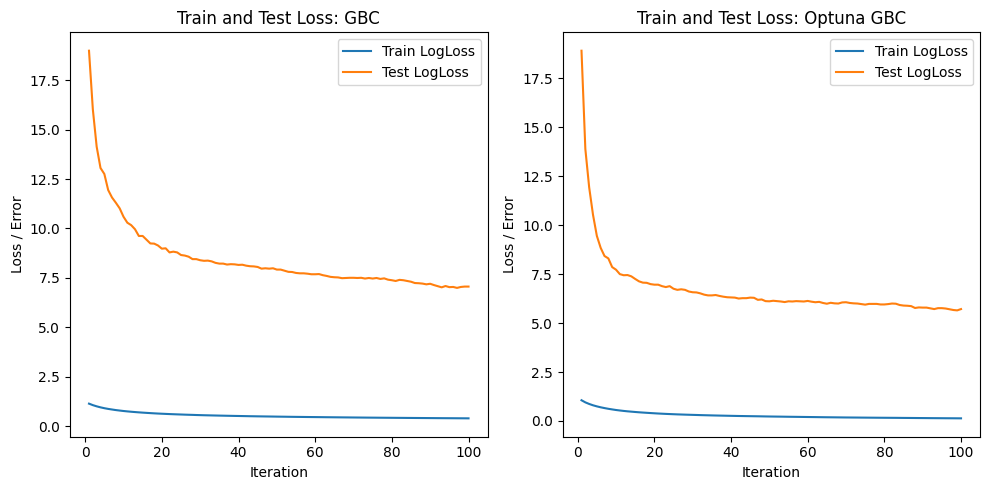

In [6]:
from sklearn.metrics import log_loss

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
def pred_labels_to_prob(pred_labels, n_classes):
    probs = np.zeros((len(pred_labels), n_classes))
    for i, label in enumerate(pred_labels):
        probs[i, label] = 1.0
    return probs

def plot_train_test_scores(model, X_test, y_test, label, ax):
    train_loss = model.train_score_
    ax.plot(range(1, len(train_loss) + 1), train_loss, label=f'Train LogLoss')
    test_loss = []
    labels = np.unique(y_test).tolist()
    for y_pred in model.staged_predict(X_test):
        y_pred_prob = pred_labels_to_prob(y_pred, n_classes=5)
        test_loss.append(log_loss(y_test, y_pred_prob, labels=labels))
    ax.plot(range(1, len(test_loss) + 1), test_loss, label=f'Test LogLoss')

    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss / Error')
    ax.legend()
    ax.set_title(f'Train and Test Loss: {label}')


plot_train_test_scores(gbc, X_test, y_test, 'GBC', axs[0])
plot_train_test_scores(optuna_gbc, X_test, y_test, 'Optuna GBC', axs[1])
fig.tight_layout()
plt.show()


### CatBoost

In [ ]:
from catboost import CatBoostClassifier, Pool

In [26]:
train_pool = Pool(X_train, label=y_train)
val_pool = Pool(X_test, label=y_test)
catboost_metric = 'MultiClass'
catboost = CatBoostClassifier(eval_metric=catboost_metric, random_seed=42, iterations=200, verbose=0)
catboost.fit(X_train, y_train, eval_set=val_pool)

catboost_y_pred = catboost.predict(X_test)

catboost_acc = accuracy_score(y_test, catboost_y_pred) * 100
catboost_f1_macro = f1_score(y_test, catboost_y_pred, average='macro') * 100
catboost_f1_weighted = f1_score(y_test, catboost_y_pred, average='weighted') * 100
catboost_per_class = f1_score(y_test, catboost_y_pred, average=None) * 100

print(f"Accuracy: {catboost_acc:.2f}%")
print(f"F1-macro: {catboost_f1_macro:.2f}%")
print(f"F1-weighted: {catboost_f1_weighted:.2f}%")
print("F1 per class (%):", catboost_per_class)

Accuracy: 83.48%
F1-macro: 76.68%
F1-weighted: 83.33%
F1 per class (%): [67.88511749 82.8042328  87.63983629 79.23544744 65.83850932]


In [ ]:
def objective(trial: optuna.Trial):
    max_depth = trial.suggest_int('depth', 5, 10)
    loss_function = trial.suggest_categorical('loss_function', ['MultiClass', 'MultiClassOneVsAll'])
    
    clf = CatBoostClassifier(
        iterations=200,
        depth=max_depth,
        loss_function=loss_function,
        random_seed=42,
        verbose=0
    )
    error = cross_val_score(clf, X_train_val, y_train_val, cv=cv, scoring='f1_weighted')
    return error.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, n_jobs=6)

print("Best f1_weighted:", study.best_value)
print("Best params:", study.best_params)

train_pool = Pool(X_train, label=y_train)
val_pool = Pool(X_test, label=y_test)
optuna_catboost_metric = study.best_params['loss_function']
optuna_catboost = CatBoostClassifier(**study.best_params, eval_metric=optuna_catboost_metric, random_seed=42, iterations=200, verbose=0)
optuna_catboost.fit(X_train, y_train, eval_set=val_pool)

optuna_catboost_y_pred = optuna_catboost.predict(X_test)

optuna_catboost_acc = accuracy_score(y_test, optuna_catboost_y_pred) * 100
optuna_catboost_f1_macro = f1_score(y_test, optuna_catboost_y_pred, average='macro') * 100
optuna_catboost_f1_weighted = f1_score(y_test, optuna_catboost_y_pred, average='weighted') * 100
optuna_catboost_per_class = f1_score(y_test, optuna_catboost_y_pred, average=None) * 100

print(f"Accuracy: {optuna_catboost_acc:.2f}%")
print(f"F1-macro: {optuna_catboost_f1_macro:.2f}%")
print(f"F1-weighted: {optuna_catboost_f1_weighted:.2f}%")
print("F1 per class (%):", optuna_catboost_per_class)


[I 2025-10-30 18:26:03,309] A new study created in memory with name: no-name-bc1be1c9-d4f7-474d-a00e-abe3cee9bcaf
[I 2025-10-30 18:26:40,604] Trial 3 finished with value: 0.8431907942210286 and parameters: {'depth': 6, 'loss_function': 'MultiClass'}. Best is trial 3 with value: 0.8431907942210286.
[I 2025-10-30 18:26:41,242] Trial 5 finished with value: 0.8431907942210286 and parameters: {'depth': 6, 'loss_function': 'MultiClass'}. Best is trial 3 with value: 0.8431907942210286.
[I 2025-10-30 18:26:42,548] Trial 0 finished with value: 0.8431907942210286 and parameters: {'depth': 6, 'loss_function': 'MultiClass'}. Best is trial 3 with value: 0.8431907942210286.
[I 2025-10-30 18:27:42,145] Trial 6 finished with value: 0.7910858025781465 and parameters: {'depth': 7, 'loss_function': 'MultiClassOneVsAll'}. Best is trial 3 with value: 0.8431907942210286.
[I 2025-10-30 18:27:42,867] Trial 8 finished with value: 0.7910858025781465 and parameters: {'depth': 7, 'loss_function': 'MultiClassOneVs

Best f1_weighted: 0.8447776071432624
Best params: {'depth': 7, 'loss_function': 'MultiClass'}
Accuracy: 83.72%
F1-macro: 77.42%
F1-weighted: 83.55%
F1 per class (%): [68.25396825 82.77703605 87.85249458 79.51388889 68.71165644]


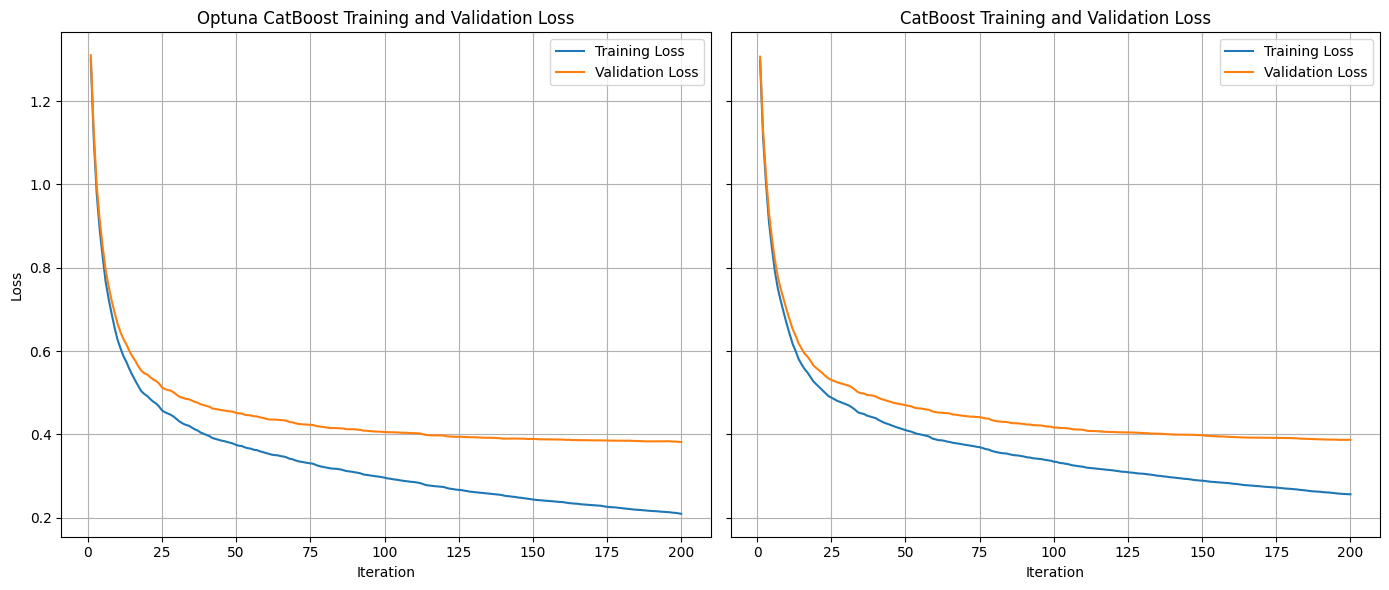

In [ ]:
optuna_catboost_evals_result = optuna_catboost.get_evals_result()
optuna_catboost_train_loss = optuna_catboost_evals_result['learn'][optuna_catboost_metric]
optuna_catboost_val_loss = optuna_catboost_evals_result['validation'][optuna_catboost_metric]
iterations_optuna = np.arange(1, len(optuna_catboost_train_loss) + 1)

catboost_evals_result = catboost.get_evals_result()
catboost_train_loss = catboost_evals_result['learn']['MultiClass']
catboost_val_loss = catboost_evals_result['validation']['MultiClass']
catboost_iterations = np.arange(1, len(catboost_train_loss) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].plot(iterations_optuna, optuna_catboost_train_loss, label='Training Loss')
axes[0].plot(iterations_optuna, optuna_catboost_val_loss, label='Validation Loss')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('Optuna CatBoost Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(catboost_iterations, catboost_train_loss, label='Training Loss')
axes[1].plot(catboost_iterations, catboost_val_loss, label='Validation Loss')
axes[1].set_xlabel('Iteration')
axes[1].set_title('CatBoost Training and Validation Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


### XGBoost

In [ ]:
from xgboost import XGBClassifier

XGBoost показывал переобучение (ошибка на тесте начинала увеличиваться) поэтому пришлось переписать cross_val_score с параметром early_stopping_rounds

In [58]:

eval_set = [(X_train, y_train), (X_test, y_test)]
xgb = XGBClassifier(n_estimators=200, objective='multi:softprob', 
                          num_class=5, use_label_encoder=False, eval_metric='mlogloss', 
                          random_state=42, verbosity=0, early_stopping_rounds=5)
xgb.fit(X_train, y_train, eval_set=eval_set, verbose=0)
xgb_y_pred = xgb.predict(X_test)

xgb_acc = accuracy_score(y_test, xgb_y_pred) * 100
xgb_f1_macro = f1_score(y_test, xgb_y_pred, average='macro') * 100
xgb_f1_weighted = f1_score(y_test, xgb_y_pred, average='weighted') * 100
xgb_per_class = f1_score(y_test, xgb_y_pred, average=None) * 100

print(f"Accuracy: {xgb_acc:.2f}%")
print(f"F1-macro: {xgb_f1_macro:.2f}%")
print(f"F1-weighted: {xgb_f1_weighted:.2f}%")
print("F1 per class (%):", xgb_per_class)

Accuracy: 85.06%
F1-macro: 79.66%
F1-weighted: 84.95%
F1 per class (%): [71.39107612 84.03361345 88.73738751 81.74672489 72.4137931 ]


In [ ]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'tree_method': trial.suggest_categorical('tree_method', ['approx', 'hist']),
        'objective': 'multi:softprob',
        'num_class': 5,
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'verbosity': 0
    }

    scores = []
    for train_idx, val_idx in cv.split(X_train_val, y_train_val):
        X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

        clf = XGBClassifier(**params, n_estimators=200, early_stopping_rounds=5)
        clf.fit(X_train_fold, y_train_fold,
                eval_set=[(X_val_fold, y_val_fold)],
                verbose=False)

        preds = clf.predict(X_val_fold)
        score = f1_score(y_val_fold, preds, average='weighted')
        scores.append(score)
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=45, n_jobs=6)

print("Best f1_weighted:", study.best_value)
print("Best params:", study.best_params)

eval_set = [(X_train, y_train), (X_test, y_test)]
optuna_xgb = XGBClassifier(**study.best_params, n_estimators=200, objective='multi:softprob', 
                          num_class=5, use_label_encoder=False, eval_metric='mlogloss', 
                          random_state=42, verbosity=0, early_stopping_rounds=5)
optuna_xgb.fit(X_train, y_train, eval_set=eval_set, verbose=0)
optuna_xgb_y_pred = optuna_xgb.predict(X_test)

optuna_xgb_acc = accuracy_score(y_test, optuna_xgb_y_pred) * 100
optuna_xgb_f1_macro = f1_score(y_test, optuna_xgb_y_pred, average='macro') * 100
optuna_xgb_f1_weighted = f1_score(y_test, optuna_xgb_y_pred, average='weighted') * 100
optuna_xgb_per_class = f1_score(y_test, optuna_xgb_y_pred, average=None) * 100

print(f"Accuracy: {optuna_xgb_acc:.2f}%")
print(f"F1-macro: {optuna_xgb_f1_macro:.2f}%")
print(f"F1-weighted: {optuna_xgb_f1_weighted:.2f}%")
print("F1 per class (%):", optuna_xgb_per_class)

Best f1_weighted: 0.8519217543166657
Best params: {'max_depth': 8, 'learning_rate': 0.22440056605906153, 'gamma': 0.0444695165106026, 'grow_policy': 'depthwise', 'tree_method': 'approx'}
Accuracy: 83.98%
F1-macro: 77.77%
F1-weighted: 83.84%
F1 per class (%): [66.84350133 82.63367212 88.11989101 81.08108108 70.1754386 ]


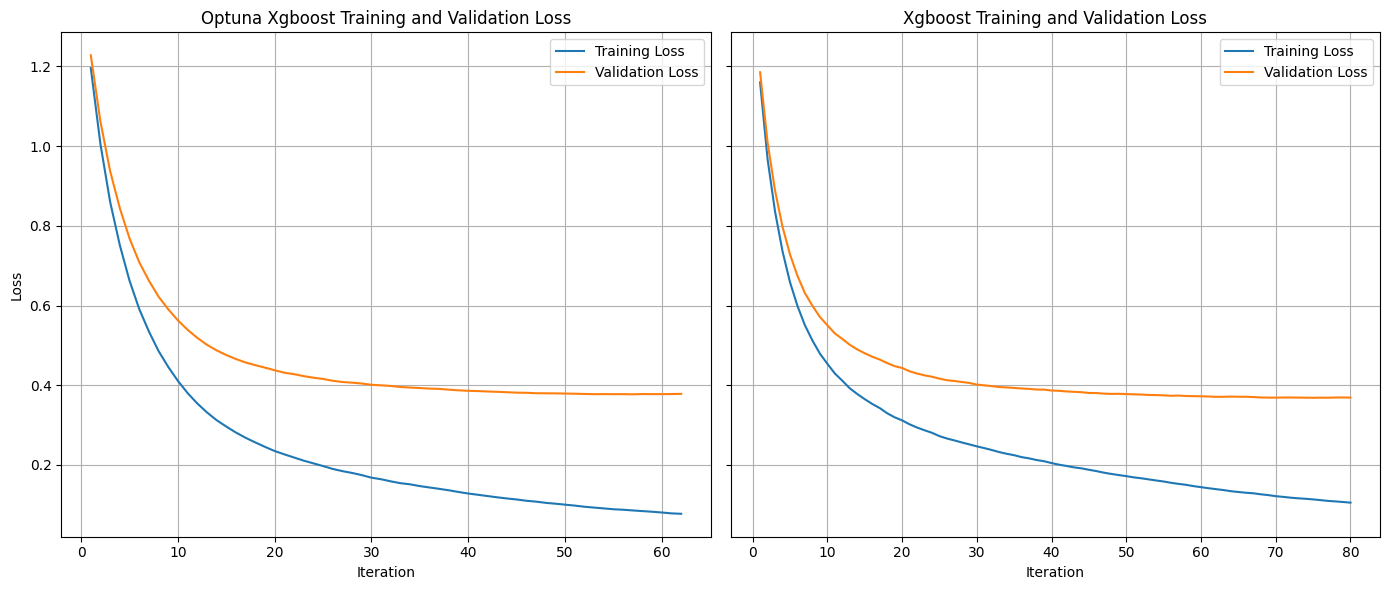

In [71]:
optuna_xgb_evals_result = optuna_xgb.evals_result()
optuna_xgb_train_loss = optuna_xgb_evals_result['validation_0']['mlogloss']
optuna_xgb_val_loss = optuna_xgb_evals_result['validation_1']['mlogloss']
iterations_optuna = np.arange(1, len(optuna_xgb_train_loss) + 1)

xgb_evals_result = xgb.evals_result()
xgb_train_loss = xgb_evals_result['validation_0']['mlogloss']
xgb_val_loss = xgb_evals_result['validation_1']['mlogloss']
xgb_iterations = np.arange(1, len(xgb_train_loss) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].plot(iterations_optuna, optuna_xgb_train_loss, label='Training Loss')
axes[0].plot(iterations_optuna, optuna_xgb_val_loss, label='Validation Loss')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('Optuna Xgboost Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(xgb_iterations, xgb_train_loss, label='Training Loss')
axes[1].plot(xgb_iterations, xgb_val_loss, label='Validation Loss')
axes[1].set_xlabel('Iteration')
axes[1].set_title('Xgboost Training and Validation Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


### LightGB

In [ ]:
from lightgbm import LGBMClassifier, plot_metric

In [37]:
lgbm = LGBMClassifier(
    verbosity = -1,
    n_estimators = 200, 
    class_weight='balanced')
lgbm.fit(X_train, y_train, eval_set=eval_set, eval_metric='multi_logloss')

lgbm_y_pred = lgbm.predict(X_test)

lgbm_acc = accuracy_score(y_test, lgbm_y_pred) * 100
lgbm_f1_macro = f1_score(y_test, lgbm_y_pred, average='macro') * 100
lgbm_f1_weighted = f1_score(y_test, lgbm_y_pred, average='weighted') * 100
lgbm_per_class = f1_score(y_test, lgbm_y_pred, average=None) * 100

print(f"Accuracy: {lgbm_acc:.2f}%")
print(f"F1-macro: {lgbm_f1_macro:.2f}%")
print(f"F1-weighted: {lgbm_f1_weighted:.2f}%")
print("F1 per class (%):", lgbm_per_class)

Accuracy: 83.82%
F1-macro: 79.91%
F1-weighted: 83.90%
F1 per class (%): [69.68973747 82.89473684 87.19113888 81.53594771 78.26086957]


In [43]:
def objective(trial: optuna.Trial):
    params = {
        'objective': trial.suggest_categorical('objective', ('multiclass', 'multiclassova')),
        'metric': trial.suggest_categorical('metric', ('multi_logloss', 'multi_error')),
        'max_depth' : trial.suggest_int('max_depth', 5, 10),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
    }
    
    model = LGBMClassifier(**params,
                           verbosity = -1,
                           n_estimators = 200, 
                           class_weight='balanced')
    error = cross_val_score(model, X_train_val, y_train_val, cv=cv, scoring='f1_weighted')
    return error.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=45, n_jobs=6)

print("Best f1_weighted:", study.best_value)
print("Best params:", study.best_params)

optuna_lgbm = LGBMClassifier(
    **study.best_params,
    verbosity = -1,
    n_estimators = 200, 
    class_weight='balanced')
optuna_lgbm.fit(X_train, y_train, eval_set=eval_set, eval_metric='multi_logloss')

optuna_lgbm_y_pred = optuna_lgbm.predict(X_test)

optuna_lgbm_acc = accuracy_score(y_test, optuna_lgbm_y_pred) * 100
optuna_lgbm_f1_macro = f1_score(y_test, optuna_lgbm_y_pred, average='macro') * 100
optuna_lgbm_f1_weighted = f1_score(y_test, optuna_lgbm_y_pred, average='weighted') * 100
optuna_lgbm_per_class = f1_score(y_test, optuna_lgbm_y_pred, average=None) * 100

print(f"Accuracy: {optuna_lgbm_acc:.2f}%")
print(f"F1-macro: {optuna_lgbm_f1_macro:.2f}%")
print(f"F1-weighted: {optuna_lgbm_f1_weighted:.2f}%")
print("F1 per class (%):", optuna_lgbm_per_class)

[I 2025-10-30 20:52:23,475] A new study created in memory with name: no-name-69187545-3b41-4777-8048-1ab2e6f99f40
[I 2025-10-30 20:53:20,665] Trial 3 finished with value: 0.791979552103858 and parameters: {'objective': 'multiclass', 'metric': 'multi_error', 'max_depth': 6, 'num_leaves': 79, 'learning_rate': 0.01627650634778796}. Best is trial 3 with value: 0.791979552103858.
[I 2025-10-30 20:53:34,586] Trial 1 finished with value: 0.8539857945372805 and parameters: {'objective': 'multiclassova', 'metric': 'multi_error', 'max_depth': 7, 'num_leaves': 169, 'learning_rate': 0.14202922548786046}. Best is trial 1 with value: 0.8539857945372805.
[I 2025-10-30 20:53:43,148] Trial 0 finished with value: 0.8425348619965669 and parameters: {'objective': 'multiclassova', 'metric': 'multi_error', 'max_depth': 8, 'num_leaves': 69, 'learning_rate': 0.04279109964109746}. Best is trial 1 with value: 0.8539857945372805.
[I 2025-10-30 20:54:17,344] Trial 5 finished with value: 0.8458372184961422 and par

Best f1_weighted: 0.8563938893950324
Best params: {'objective': 'multiclassova', 'metric': 'multi_error', 'max_depth': 10, 'num_leaves': 168, 'learning_rate': 0.07633875827177233}
Accuracy: 84.01%
F1-macro: 79.53%
F1-weighted: 84.03%
F1 per class (%): [69.73365617 82.55506608 87.70949721 81.82586644 75.82417582]


/home/max/work_area/python_direct/venv/lib/python3.12/site-packages/lightgbm/plotting.py:382: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


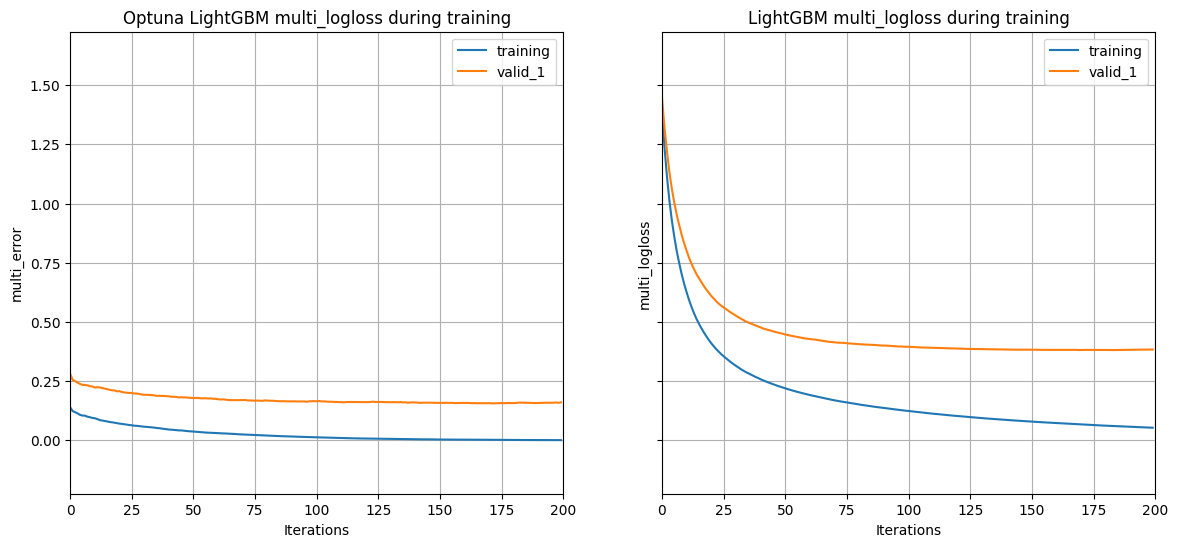

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plot_metric(optuna_lgbm, ax=axes[0])
axes[0].set_title("Optuna LightGBM multi_logloss during training")

plot_metric(lgbm, ax=axes[1])
axes[1].set_title("LightGBM multi_logloss during training")

plt.show()

### Выводы

Видим что для всех алгоритмов
На всех методах кроме Xgboosting подбор гиперпараметров с помощью Optuna давал прирост f1-weighted на ~1%. В случае с Xgboost значение метрики снизилось, вероятно, в подборе не учавствовали параметры используюемые по умолчанию, либо было получено переобучение на выборке train_val. Значение метрик для всех алгоритмов бустинга выше чем у Random Forest. 

Для одополнительной оценки посмотрим на матрицы ошибок.

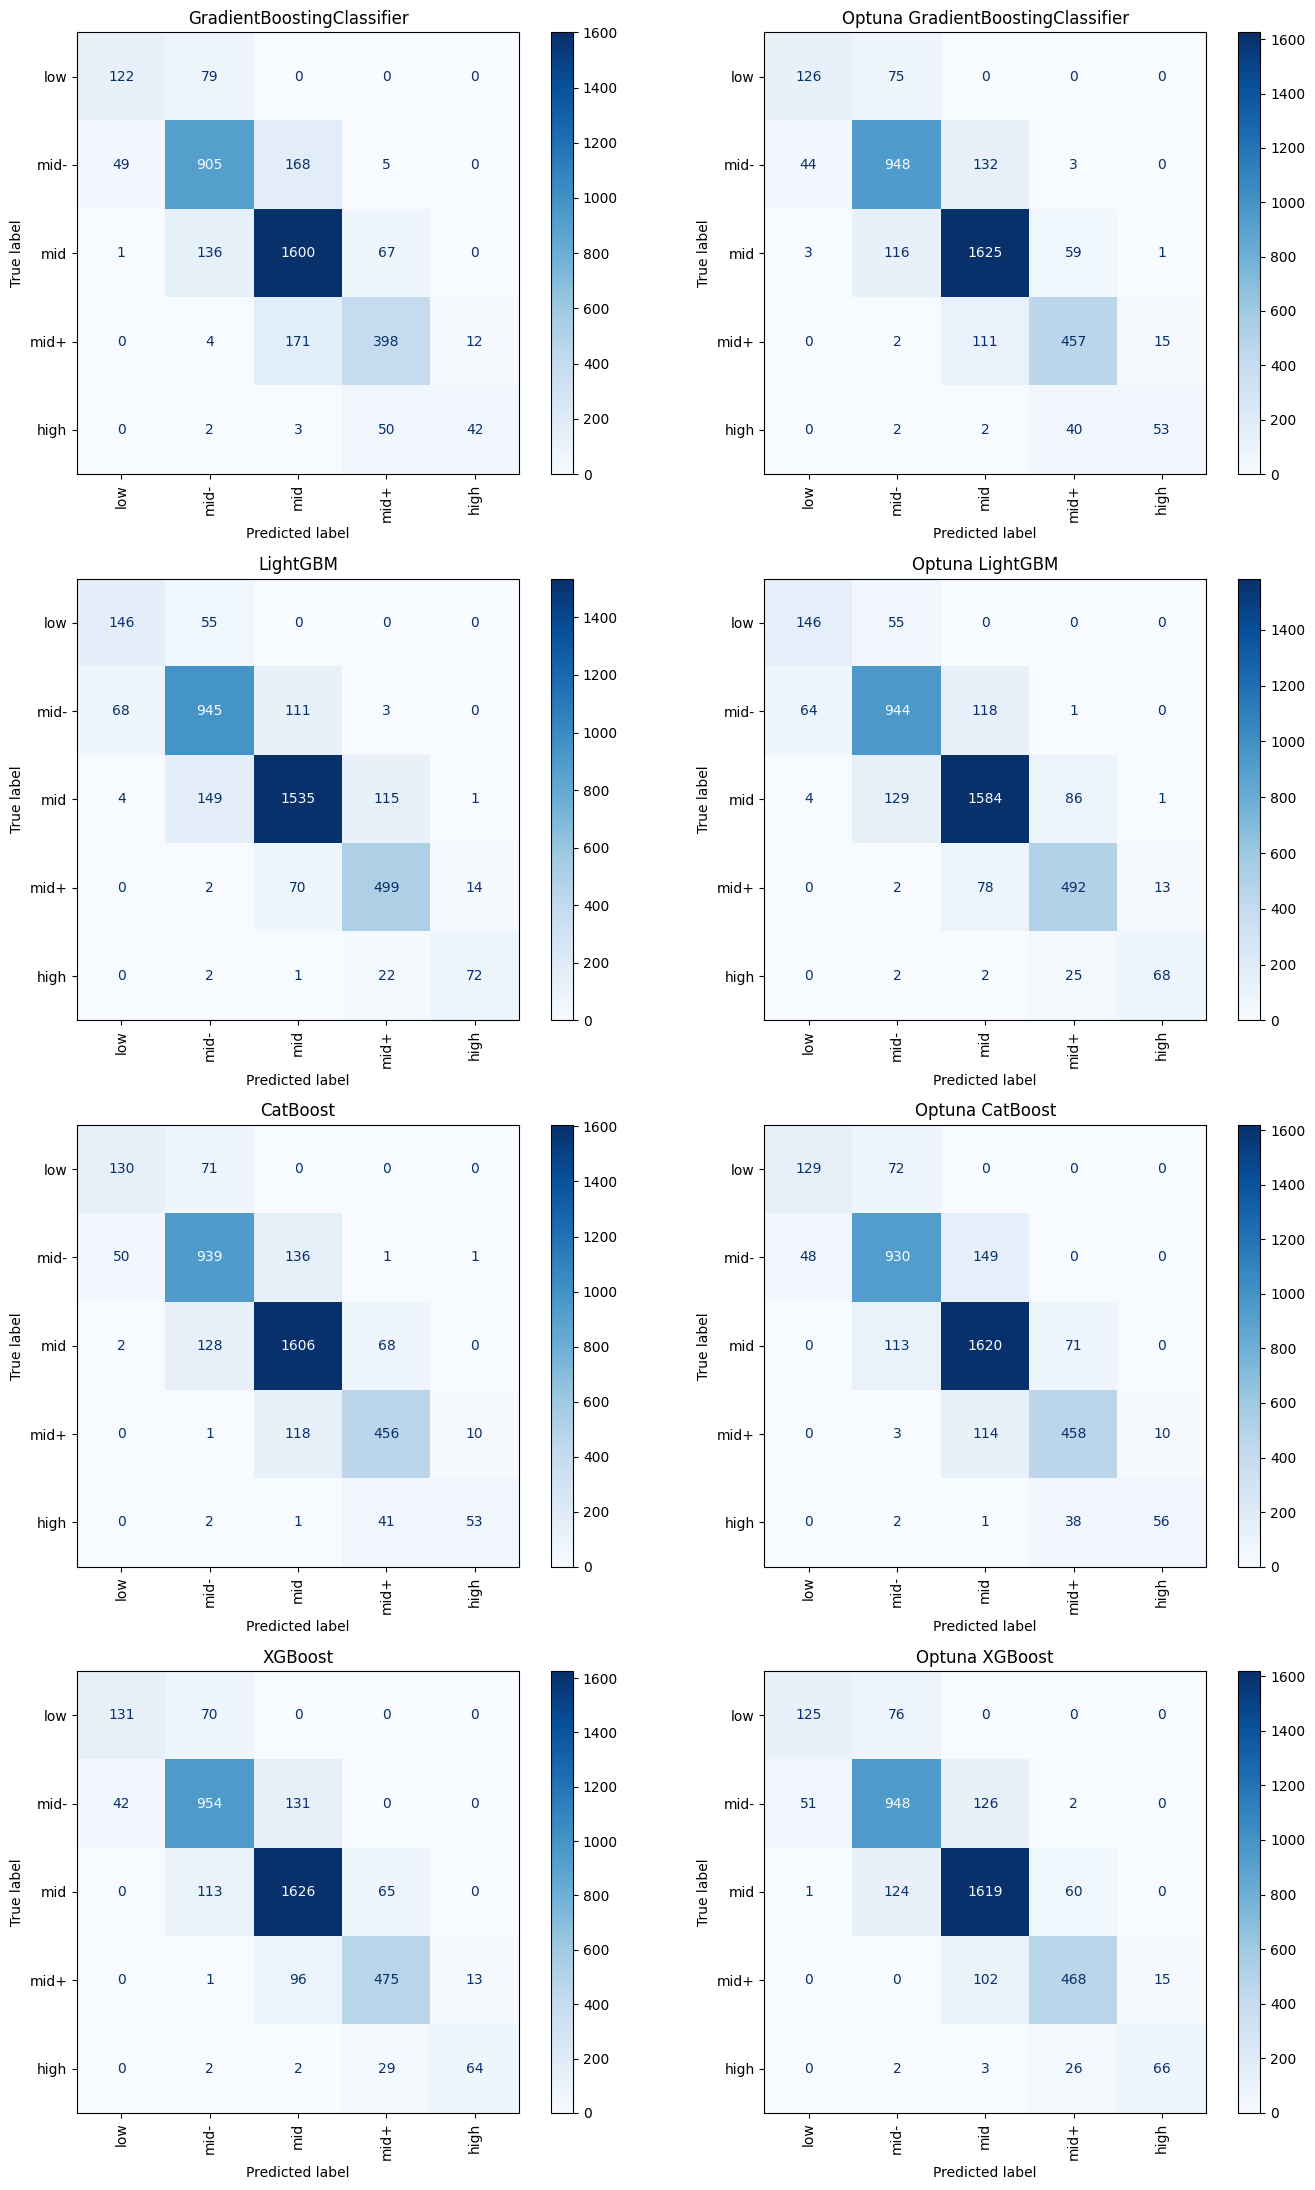

In [42]:
def plot_confusion_matrix(y_true, y_pred, label, ax):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_y)
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    ax.set_title(label)

fig, axs = plt.subplots(4, 2, figsize=(14, 22))

plot_confusion_matrix(y_test, gbc_y_pred, 'GradientBoostingClassifier', axs[0, 0])
plot_confusion_matrix(y_test, optuna_gbc_y_pred, 'Optuna GradientBoostingClassifier', axs[0, 1])
plot_confusion_matrix(y_test, lgbm_y_pred, 'LightGBM', axs[1, 0])
plot_confusion_matrix(y_test, optuna_lgbm_y_pred, 'Optuna LightGBM', axs[1, 1])
plot_confusion_matrix(y_test, catboost_y_pred, 'CatBoost', axs[2, 0])
plot_confusion_matrix(y_test, optuna_catboost_y_pred, 'Optuna CatBoost', axs[2, 1])
plot_confusion_matrix(y_test, xgb_y_pred, 'XGBoost', axs[3, 0])
plot_confusion_matrix(y_test, optuna_xgb_y_pred, 'Optuna XGBoost', axs[3, 1])

plt.tight_layout()
plt.show()

Видим, что некоторые ошибки как например предсказание mid- для двух экземпляров high соответсвует всем моделям. Так же в ходе работы я видел, что переобученные модели не выдавали f1_weighted > 86%, то есть существуют "ошибки" (шумы) присущие самому датасету. Если просмотреть все модели для классификации за оследние 3 дз, то увидим что эти ошибки сохраняются.

Итог: Все методы градиентного бустинга подходят для решения задачи, XGBoost - лучшая модель, она допускает наименьшее количество "грубых" ошибок (напоминание: грубыми считаются ошибки более чем на соседние классы), худшая классический Gradient Boosting 

## Регрессия

In [73]:
data_new = df.drop(columns=['price_category', 'personal_using', 'automatic_emergency_braking', 'drivetrain_Unknown', 'brand', 'model', 'engine', 'transmission', 'interior_color', 'exterior_color', 'min_mpg', 'max_mpg'])

X = data_new.drop(columns=['price'])
y = data_new['price'] / 1000
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1/0.8, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

columns_to_scale = ['year', 'mileage', 'engine_size', 'avg_mpg',
                    'brand_freq', 'model_freq', 'engine_freq', 'transmission_freq',
                    'interior_color_freq', 'exterior_color_freq']

scaler = StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
X_train.head()

,year,mileage,engine_size,automatic_transmission,fuel_type,damaged,first_owner,turbo,alloy_wheels,adaptive_cruise_control,...,brand_freq,model_freq,engine_freq,transmission_freq,interior_color_freq,exterior_color_freq,drivetrain_Four-wheel Drive,drivetrain_Front-wheel Drive,drivetrain_Rear-wheel Drive,avg_mpg
6610,0.453054,-0.205385,-0.721192,True,5,False,True,True,True,True,...,-0.573261,-0.225248,-0.558232,0.208364,-0.933212,-0.486926,True,False,False,-0.273455
6606,0.863384,-1.167348,-0.721192,True,5,False,False,True,True,False,...,0.280332,1.256548,2.575786,-1.038874,1.153829,-0.573113,True,False,False,-0.729397
17195,-0.777936,-0.283911,-0.721192,False,5,True,False,True,True,False,...,-0.121359,0.367470,-0.580469,-1.267329,1.153829,0.563623,True,False,False,-0.820586
16205,-0.777936,-0.878428,1.184862,True,5,False,False,False,False,False,...,-0.908004,-0.719180,-0.648569,-1.285852,-0.938617,-0.575442,False,False,True,-0.328720
8665,0.453054,-0.605844,0.107527,True,5,False,True,True,True,False,...,-0.037673,-0.356964,-0.169086,1.376877,-0.941191,-0.594077,True,False,False,-0.638209


In [22]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
gbr_y_pred = gbr.predict(X_test)
gbr_mse = mean_squared_error(y_test, gbr_y_pred)
gbr_mae = mean_absolute_error(y_test, gbr_y_pred)
gbr_r2 = r2_score(y_test, gbr_y_pred)
gbr_rmse = root_mean_squared_error(y_test, gbr_y_pred)

print(f"Test MSE: {gbr_mse:.4f}")
print(f"Test RMSE: {gbr_rmse:.4f}")
print(f"Test MAE: {gbr_mae:.4f}")
print(f"Test R2 score: {gbr_r2:.4f}")

Test MSE: 212.9424
Test RMSE: 14.5925
Test MAE: 7.0842
Test R2 score: 0.7142


In [23]:
optuna.logging.set_verbosity(optuna.logging.INFO)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial: optuna.Trial):
    # n_estimators = trial.suggest_int('n_estimators', 150, 250)
    max_depth = trial.suggest_int('max_depth', 5, 10)
    learning_rate = trial.suggest_categorical('learning_rate', (0.001, 0.01, 0.1))
    criterion = trial.suggest_categorical('criterion', ('friedman_mse', 'squared_error'))
    loss = trial.suggest_categorical('loss', ('squared_error', 'absolute_error', 'huber'))

    regressor = GradientBoostingRegressor(
        n_estimators=200,
        criterion=criterion, 
        loss=loss,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=42
    )
    error = cross_val_score(regressor, X_train_val, y_train_val, cv=cv, scoring='neg_mean_squared_error')
    return error.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40, n_jobs=6)

print("Best neg RMSE:", study.best_value)
print("Best params:", study.best_params)

optuna_gbr = GradientBoostingRegressor(**study.best_params, random_state=42)
optuna_gbr.fit(X_train, y_train)

optuna_gbr_y_pred = optuna_gbr.predict(X_test)

optuna_gbr_mse = mean_squared_error(y_test, optuna_gbr_y_pred)
optuna_gbr_mae = mean_absolute_error(y_test, optuna_gbr_y_pred)
optuna_gbr_r2 = r2_score(y_test, optuna_gbr_y_pred)
optuna_gbr_rmse = root_mean_squared_error(y_test, optuna_gbr_y_pred)

print(f"Test MSE: {optuna_gbr_mse:.4f}")
print(f"Test RMSE: {optuna_gbr_rmse:.4f}")
print(f"Test MAE: {optuna_gbr_mae:.4f}")
print(f"Test R2 score: {optuna_gbr_r2:.4f}")

[I 2025-10-30 18:59:25,530] A new study created in memory with name: no-name-5139a070-9a69-4c8f-a248-ac2c8a3cc4d1
[I 2025-10-30 19:00:40,307] Trial 0 finished with value: -126.78433849591745 and parameters: {'max_depth': 8, 'learning_rate': 0.1, 'criterion': 'friedman_mse', 'loss': 'squared_error'}. Best is trial 0 with value: -126.78433849591745.
[I 2025-10-30 19:00:41,460] Trial 3 finished with value: -168.12895727556062 and parameters: {'max_depth': 8, 'learning_rate': 0.01, 'criterion': 'friedman_mse', 'loss': 'squared_error'}. Best is trial 0 with value: -126.78433849591745.
[I 2025-10-30 19:00:47,958] Trial 1 finished with value: -729.6745613360763 and parameters: {'max_depth': 5, 'learning_rate': 0.001, 'criterion': 'squared_error', 'loss': 'absolute_error'}. Best is trial 0 with value: -126.78433849591745.
[I 2025-10-30 19:00:58,705] Trial 5 finished with value: -587.748965656049 and parameters: {'max_depth': 10, 'learning_rate': 0.001, 'criterion': 'friedman_mse', 'loss': 'squ

Best neg RMSE: -116.99870428437114
Best params: {'max_depth': 7, 'learning_rate': 0.1, 'criterion': 'squared_error', 'loss': 'huber'}
Test MSE: 145.2715
Test RMSE: 12.0529
Test MAE: 4.8118
Test R2 score: 0.8050


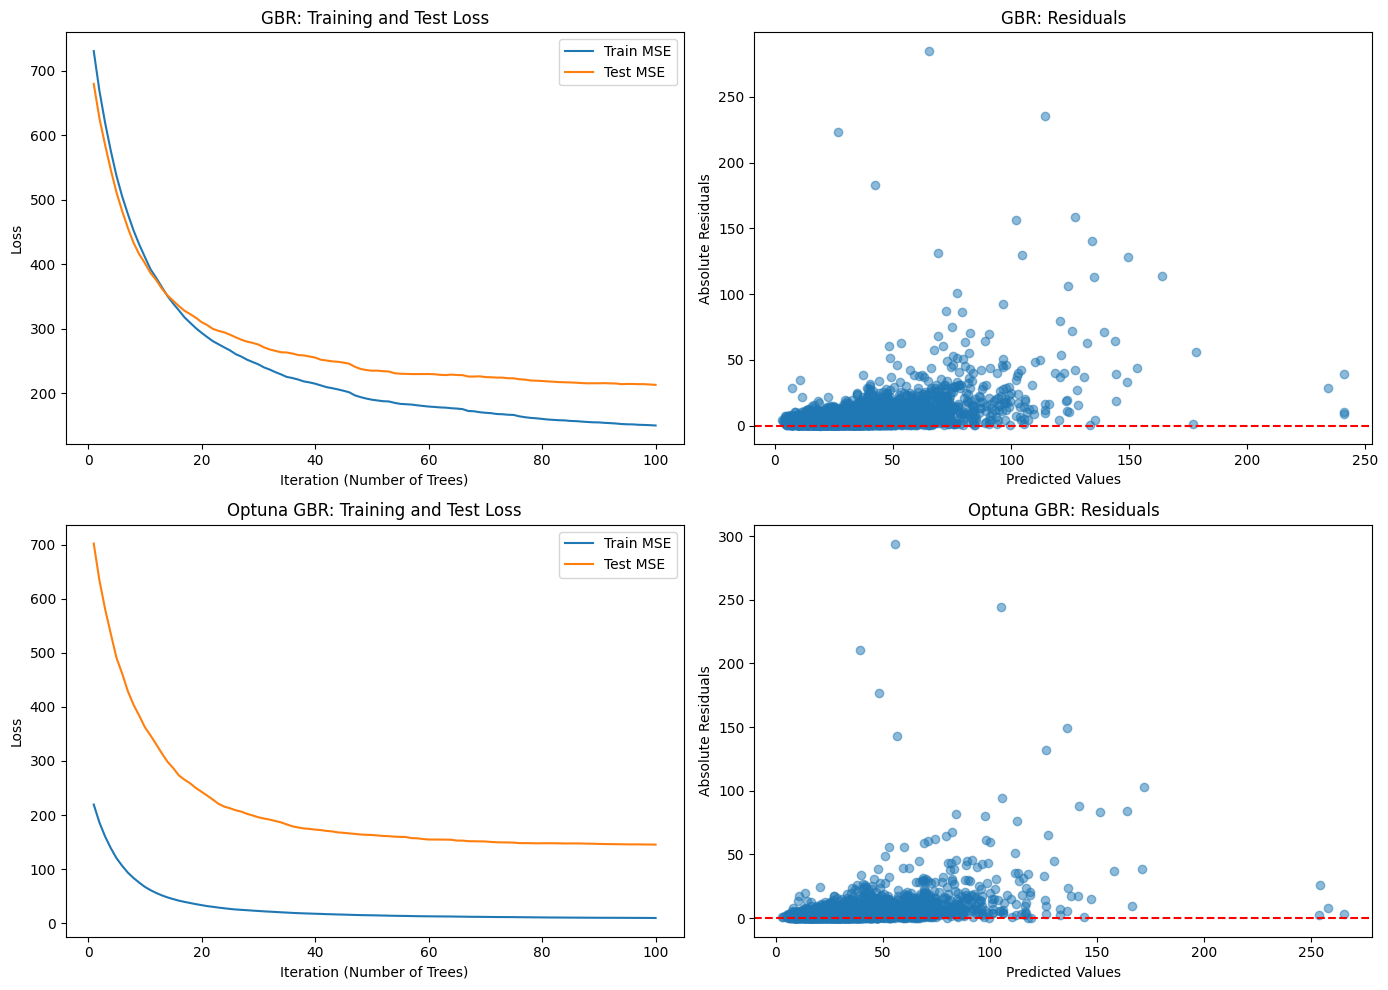

In [74]:
train_error_gbr = gbr.train_score_
test_errors_gbr = [mean_squared_error(y_test, y_pred) for y_pred in gbr.staged_predict(X_test)]
residuals_gbr = abs(y_test - gbr_y_pred)

train_error_optuna = optuna_gbr.train_score_
test_errors_optuna = [mean_squared_error(y_test, y_pred) for y_pred in optuna_gbr.staged_predict(X_test)]
residuals_optuna = abs(y_test - optuna_gbr_y_pred)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(range(1, len(train_error_gbr) + 1), train_error_gbr, label='Train MSE')
axs[0, 0].plot(range(1, len(test_errors_gbr) + 1), test_errors_gbr, label='Test MSE')
axs[0, 0].set_title('GBR: Training and Test Loss')
axs[0, 0].set_xlabel('Iteration (Number of Trees)')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

axs[0, 1].scatter(gbr_y_pred, residuals_gbr, alpha=0.5)
axs[0, 1].axhline(y=0, color='red', linestyle='--')
axs[0, 1].set_title('GBR: Residuals')
axs[0, 1].set_xlabel('Predicted Values')
axs[0, 1].set_ylabel('Absolute Residuals')

axs[1, 0].plot(range(1, len(train_error_optuna) + 1), train_error_optuna, label='Train MSE')
axs[1, 0].plot(range(1, len(test_errors_optuna) + 1), test_errors_optuna, label='Test MSE')
axs[1, 0].set_title('Optuna GBR: Training and Test Loss')
axs[1, 0].set_xlabel('Iteration (Number of Trees)')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

axs[1, 1].scatter(optuna_gbr_y_pred, residuals_optuna, alpha=0.5)
axs[1, 1].axhline(y=0, color='red', linestyle='--')
axs[1, 1].set_title('Optuna GBR: Residuals')
axs[1, 1].set_xlabel('Predicted Values')
axs[1, 1].set_ylabel('Absolute Residuals')

plt.tight_layout()
plt.show()


Предположим, что нас устраивает погрешность в 500$. Посмотрим долю допустимых предсказаний.

In [75]:
count_gbr_large_err = (residuals_gbr < 0.5).sum() / len(residuals_gbr)
count_optuna_large_err = (residuals_optuna < 0.5).sum() / len(residuals_optuna)


print(f"GBR residuals < 500$: {count_gbr_large_err}")
print(f"Optuna GBR residuals < 500$: {count_optuna_large_err}")

GBR residuals < 500$: 0.07760880964866282
Optuna GBR residuals < 500$: 0.10618772941793393


Любопытно что разница между GB и RF регрессорами меньше 0.01 на RMSE. Доля допустимых предсказаний слишком мала. Деревья не справляются с регрессией на этой задаче.